In [1]:
import glob
import pandas as pd
import calendar
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_files():
    filelist = []

    for file in (glob.glob("*.txt")):
        filelist.append(file)
        list_dfs = [pd.read_csv(file) for file in filelist]

    df = pd.concat(list_dfs, ignore_index=True)
    df.columns = df.columns.str.strip()
    return df

df = read_files()


In [3]:
#Clean up data

#change time and dates
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format='%m/%d/%Y %H:%M:%S')
df['DATE'] = pd.to_datetime(df.DATE,format='%m/%d/%Y')
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name


#drop path and srt
df.drop(df[df.DIVISION == 'PTH'].index, inplace=True)
df.drop(df[df.DIVISION == 'SRT'].index, inplace=True)

#clean turnstiles and stations
df['TURNSTILE'] = df['C/A'] + ' ' + df['SCP']
df['STATION_LINE'] = df['STATION'] + '-' + df['LINENAME']

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY_OF_WEEK,TURNSTILE,STATION_LINE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227,2018-09-22 00:00:00,Saturday,A002 02-00-00,59 ST-NQR456W
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230,2018-09-22 04:00:00,Saturday,A002 02-00-00,59 ST-NQR456W
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258,2018-09-22 08:00:00,Saturday,A002 02-00-00,59 ST-NQR456W
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323,2018-09-22 12:00:00,Saturday,A002 02-00-00,59 ST-NQR456W
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368,2018-09-22 16:00:00,Saturday,A002 02-00-00,59 ST-NQR456W


In [4]:
#More cleaning
df_date = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df_hour = pd.to_datetime(df['TIME']).dt.hour

#Adjust date and times
df_date[(df_hour==22)|(df_hour==23)] += datetime.timedelta(days=1)
df_day = df[(df_hour==22)|(df_hour==23)|(df_hour==0)|(df_hour==1)]

turnstile_audits = df_day.groupby(['TURNSTILE'])['DATETIME'].nunique().to_frame().reset_index()
turnstile_audits = turnstile_audits.rename(columns={'DATETIME':'AUDITS'})

df_day = pd.merge(df_day, turnstile_audits, on='TURNSTILE')

df_day.drop(df_day.index[
    (df_day['TIME']!='01:00:00')&
    (df_day['TIME']!='00:00:00')],inplace=True)

df_day.drop(df_day.index[df_day['DESC']!='REGULAR'], inplace=True)

df_day.loc[:, 'DAILY_ENTRIES'] = df_day.groupby(['TURNSTILE'])['ENTRIES'].diff().shift(-1)
df_day.loc[:, 'DAILY_EXITS'] = df_day.groupby(['TURNSTILE'])['EXITS'].diff().shift(-1)
df_day.drop(df_day.index[df_day['DAILY_ENTRIES']<=0], inplace=True)
df_day = df_day.dropna()

df_day = df_day[['TURNSTILE', 'STATION_LINE', 'STATION', 'LINENAME', 'DATE', 'DAY_OF_WEEK', 'DAILY_ENTRIES','DAILY_EXITS']]
df_day.head(25)

,TURNSTILE,STATION_LINE,STATION,LINENAME,DATE,DAY_OF_WEEK,DAILY_ENTRIES,DAILY_EXITS
0,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-22,Saturday,709.0,199.0
1,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-23,Sunday,472.0,151.0
2,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-24,Monday,1397.0,561.0
3,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-25,Tuesday,1488.0,544.0
4,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-26,Wednesday,1506.0,581.0
5,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-09-27,Thursday,1538.0,534.0
7,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-08-25,Saturday,616.0,276.0
8,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-08-26,Sunday,453.0,196.0
9,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-08-27,Monday,1294.0,465.0
10,A002 02-00-00,59 ST-NQR456W,59 ST,NQR456W,2018-08-28,Tuesday,1374.0,387.0


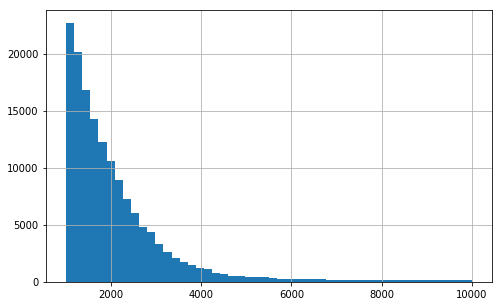

In [5]:
hist_values = df_day[(df_day['DAILY_ENTRIES'] < 10000)&
                     (df_day['DAILY_ENTRIES'] > 1000)]
hist_values['DAILY_ENTRIES'].hist(bins=50, figsize=(8,5))

index_max = hist_values['DAILY_ENTRIES'].idxmax()
df_day.loc[index_max-10:index_max+10]
df[(df['TURNSTILE']==df_day['TURNSTILE'][index_max])].head(10)

df_day = df_day[(df_day['DAILY_ENTRIES']<10000)]

In [6]:
df_hour = df.copy()
df_hour['HOURLY_ENTRIES']= df_hour.groupby(['TURNSTILE'])['ENTRIES'].diff().shift(-1)
df_hour['HOURLY_EXITS']= df_hour.groupby(['TURNSTILE'])['EXITS'].diff().shift(-1)
df_hour['HOURLY_TOTAL'] = df_hour['HOURLY_ENTRIES'] + df_hour['HOURLY_EXITS']
df_hour['DAY_CODE'] = df_hour['DATE'].dt.weekday

#Filter data to realistic Counts_Hour
df_hour.drop(df_hour.index[df_hour['HOURLY_TOTAL']<0], inplace=True)
df_hour.drop(df_hour.index[df_hour['HOURLY_TOTAL']>8000], inplace=True)
df_hour.drop(df_hour.index[df_hour['DESC']!='REGULAR'], inplace=True)

#Filter data to remove audits where 'DESC' == 'REGULAR' but still has irregular audits
df_hour.drop(df_hour.index[
    (df_hour['TIME']!='00:00:00')&
     (df_hour['TIME']!='01:00:00')&
     (df_hour['TIME']!='02:00:00')&
      (df_hour['TIME']!='03:00:00')&
      (df_hour['TIME']!='04:00:00')&
       (df_hour['TIME']!='05:00:00')&
        (df_hour['TIME']!='06:00:00')&
         (df_hour['TIME']!='07:00:00')&
          (df_hour['TIME']!='08:00:00')&
           (df_hour['TIME']!='09:00:00')&
            (df_hour['TIME']!='10:00:00')&
             (df_hour['TIME']!='11:00:00')&
              (df_hour['TIME']!='12:00:00')&
               (df_hour['TIME']!='13:00:00')&
                (df_hour['TIME']!='14:00:00')&
                 (df_hour['TIME']!='15:00:00')&
                  (df_hour['TIME']!='16:00:00')&
                   (df_hour['TIME']!='17:00:00')&
                    (df_hour['TIME']!='18:00:00')&
                     (df_hour['TIME']!='19:00:00')&
                      (df_hour['TIME']!='20:00:00')&
                       (df_hour['TIME']!='21:00:00')&
                        (df_hour['TIME']!='22:00:00')&
                         (df_hour['TIME']!='23:00:00')], inplace=True)

df_hour.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY_OF_WEEK,TURNSTILE,STATION_LINE,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_TOTAL,DAY_CODE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,00:00:00,REGULAR,6767488,2294227,2018-09-22 00:00:00,Saturday,A002 02-00-00,59 ST-NQR456W,11.0,3.0,14.0,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,04:00:00,REGULAR,6767499,2294230,2018-09-22 04:00:00,Saturday,A002 02-00-00,59 ST-NQR456W,18.0,28.0,46.0,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,08:00:00,REGULAR,6767517,2294258,2018-09-22 08:00:00,Saturday,A002 02-00-00,59 ST-NQR456W,90.0,65.0,155.0,5
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,12:00:00,REGULAR,6767607,2294323,2018-09-22 12:00:00,Saturday,A002 02-00-00,59 ST-NQR456W,183.0,45.0,228.0,5
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-09-22,16:00:00,REGULAR,6767790,2294368,2018-09-22 16:00:00,Saturday,A002 02-00-00,59 ST-NQR456W,267.0,40.0,307.0,5


In [7]:
df_hour = df_hour[df_hour['TURNSTILE'].isin(df_day['TURNSTILE'])]


df_turnstile_time = df_hour.groupby(['STATION_LINE','TURNSTILE','DAY_CODE','DAY_OF_WEEK','TIME'])['HOURLY_TOTAL'].sum().to_frame().reset_index()
df_turnstile_day = df_hour.groupby(['STATION_LINE','TURNSTILE','DAY_CODE','DAY_OF_WEEK'])['HOURLY_TOTAL'].sum().to_frame().reset_index()
df_turnstile_day = df_turnstile_day.rename(columns={'HOURLY_TOTAL':'DAILY_TOTAL'})

In [8]:
df_station_time = df_hour.groupby(['STATION_LINE','DAY_CODE','DAY_OF_WEEK','TIME'])['HOURLY_TOTAL'].sum().to_frame().reset_index()
df_station_day = df_hour.groupby(['STATION_LINE', 'DAY_CODE','DAY_OF_WEEK'])['HOURLY_TOTAL'].sum().to_frame().reset_index()
df_station_day = df_station_day.rename(columns={'HOURLY_TOTAL':'DAILY_TOTAL'})
df_station_day = df_station_day.sort_values('DAY_CODE', ascending=True)

In [9]:
df_station_total = df_hour.groupby(['STATION_LINE'])['HOURLY_TOTAL'].sum().to_frame().reset_index()
df_station_total = df_station_total.rename(columns={'HOURLY_TOTAL':'TOTAL'})
df_station_total = df_station_total.sort_values('TOTAL', ascending=False).reset_index()

In [10]:
df_station_total_ranked =df_station_total.head(20)
df_station_total_ranked

,index,STATION_LINE,TOTAL
0,300,GRD CNTRL-42 ST-4567S,22354169.0
1,85,34 ST-HERALD SQ-BDFMNQRW,17340671.0
2,88,34 ST-PENN STA-ACE,12558070.0
3,28,14 ST-UNION SQ-LNQR456W,11155802.0
4,421,TIMES SQ-42 ST-1237ACENQRSW,10561766.0
5,100,47-50 STS ROCK-BDFM,8724722.0
6,277,FLUSHING-MAIN-7,8506778.0
7,114,59 ST COLUMBUS-ABCD1,8424322.0
8,96,42 ST-PORT AUTH-ACENQRS1237W,8147988.0
9,325,JKSN HT-ROOSVLT-EFMR7,7309956.0


Text(0.5,0,'Traffic in Millions')

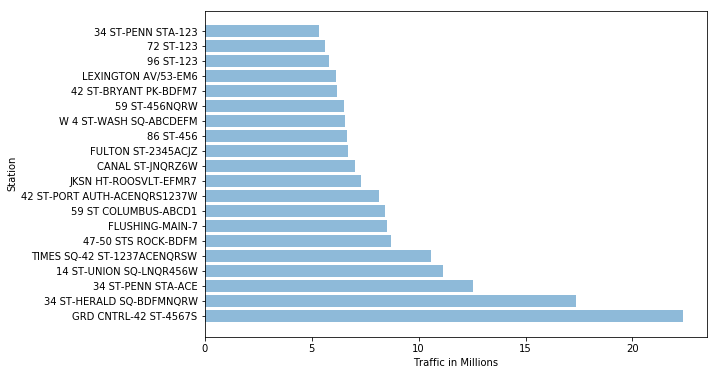

In [11]:
fig, ax = plt.subplots(1,1)
Default_Size = fig.get_size_inches()
fig.set_size_inches(Default_Size[0]*1.5, Default_Size[1]*1.5)
y_values = df_station_total_ranked['STATION_LINE']
x_values = df_station_total_ranked['TOTAL']/1000000
y_position = np.arange(len(x_values))
plt.barh(y_position, x_values, alpha = 0.5)
plt.yticks(y_position, y_values);
plt.ylabel('Station')
plt.xlabel('Traffic in Millions')

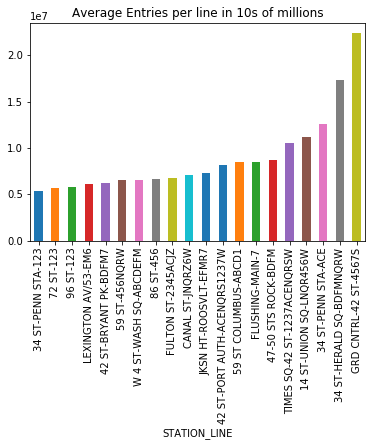

In [12]:
df_station_total_ranked.groupby(['STATION_LINE'])['TOTAL'].mean().sort_values().plot(kind='bar', title="Average Entries per line in 10s of millions");

In [13]:
#Reorder Day_of_Week columns
column_order = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#Create pivot table for all Station_Line vs Day_of_Week
df_station_day_pivot = df_station_day.pivot_table(index='STATION_LINE', 
                           values='DAILY_TOTAL', 
                           columns='DAY_OF_WEEK',
                          aggfunc=np.max)
df_station_day_pivot = df_station_day_pivot.reindex_axis(column_order, axis=1)
df_station_day_pivot

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  if __name__ == '__main__':


DAY_OF_WEEK,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
STATION_LINE,,,,,,,
1 AV-L,532423.0,575134.0,574397.0,594056.0,561459.0,442227.0,349968.0
103 ST-1,234008.0,250412.0,249787.0,256876.0,229928.0,176832.0,150705.0
103 ST-6,299321.0,310535.0,320308.0,335887.0,283958.0,184043.0,145526.0
103 ST-BC,125601.0,133496.0,126475.0,139785.0,122826.0,67805.0,58118.0
103 ST-CORONA-7,426597.0,454898.0,457253.0,474246.0,414902.0,315108.0,245799.0
104 ST-A,28222.0,30098.0,28908.0,31268.0,71655.0,15377.0,11706.0
104 ST-JZ,20903.0,22244.0,20730.0,22273.0,73949.0,5693.0,4547.0
110 ST-6,241987.0,253842.0,254278.0,264287.0,237295.0,165265.0,133443.0
111 ST-7,226287.0,236845.0,231347.0,240191.0,232344.0,190790.0,147585.0


In [14]:
df_top_station_day_pivot = df_station_day[df_station_day['STATION_LINE'].isin(df_station_total_ranked['STATION_LINE'])]
df_top_station_day_pivot = df_top_station_day_pivot.pivot_table(index='STATION_LINE',
                                   values='DAILY_TOTAL',
                                   columns='DAY_OF_WEEK',
                                   aggfunc=np.max)
df_top_station_day_pivot = df_top_station_day_pivot.reindex_axis(column_order, axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


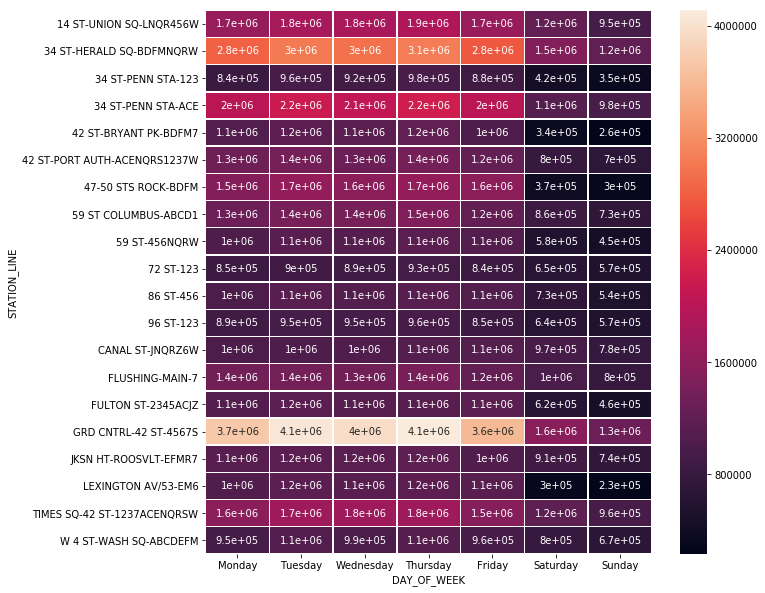

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_top_station_day_pivot, annot=True , linewidth=0.5, ax=ax)

In [16]:
df_hour_station = df_hour.groupby(['STATION_LINE','DAY_CODE','DAY_OF_WEEK','TIME'])['HOURLY_TOTAL'].sum().reset_index()

#Filter top time of each day for each station
df_hour_station = df_hour_station.sort_values(['STATION_LINE','DAY_CODE','DAY_OF_WEEK','HOURLY_TOTAL'], ascending = False)

#Add column combining Station_Line and Day_of_Week
df_hour_station['STATION_DAY'] = df_hour_station['STATION_LINE'] + ' ' + df_hour_station['DAY_OF_WEEK']

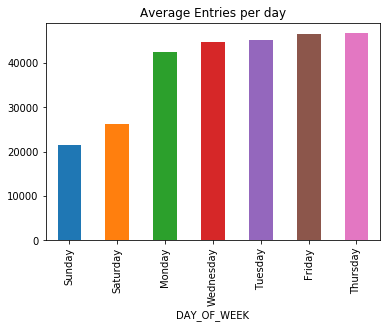

In [17]:
df_hour_station.groupby(['DAY_OF_WEEK'])['HOURLY_TOTAL'].mean().sort_values().plot(kind='bar', title="Average Entries per day");

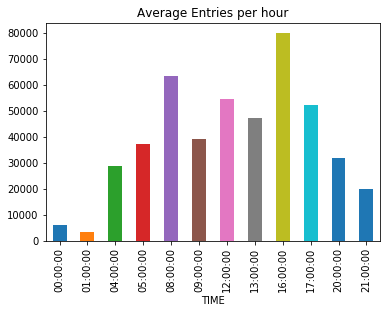

In [18]:
df_hour_station.groupby(['TIME'])['HOURLY_TOTAL'].mean().plot(kind='bar', title="Average Entries per hour");

In [19]:
weekday_pivot = df_hour_station.copy()
weekday_pivot = weekday_pivot.groupby(['STATION_LINE', 'TIME'])['HOURLY_TOTAL'].sum().reset_index()
weekday_pivot = weekday_pivot[weekday_pivot['STATION_LINE'].isin(df_station_total_ranked['STATION_LINE'])]
weekday_pivot = weekday_pivot.pivot_table(index='STATION_LINE',
                                                     values='HOURLY_TOTAL',
                                                     columns='TIME',
                                                     aggfunc=np.max)
weekday_pivot

TIME,00:00:00,01:00:00,04:00:00,05:00:00,08:00:00,09:00:00,12:00:00,13:00:00,16:00:00,17:00:00,20:00:00,21:00:00
STATION_LINE,,,,,,,,,,,,
14 ST-UNION SQ-LNQR456W,NaN,126225.0,NaN,1295709.0,NaN,2336813.0,NaN,2905137.0,NaN,3486493.0,NaN,1005425.0
34 ST-HERALD SQ-BDFMNQRW,289256.0,NaN,1172843.0,NaN,4196088.0,NaN,3636451.0,NaN,6208313.0,NaN,1837720.0,NaN
34 ST-PENN STA-123,74274.0,NaN,492723.0,NaN,1313933.0,NaN,1025397.0,NaN,1948626.0,NaN,507760.0,NaN
34 ST-PENN STA-ACE,210709.0,NaN,1327587.0,NaN,3189045.0,NaN,2485099.0,NaN,4047897.0,NaN,1297733.0,NaN
42 ST-BRYANT PK-BDFM7,104456.0,NaN,415795.0,NaN,1657195.0,NaN,1190698.0,NaN,2257868.0,NaN,580544.0,NaN
42 ST-PORT AUTH-ACENQRS1237W,125569.0,NaN,1196725.0,NaN,2024066.0,NaN,1470821.0,NaN,2449986.0,NaN,880821.0,NaN
47-50 STS ROCK-BDFM,108075.0,NaN,710715.0,NaN,2579766.0,NaN,1569927.0,NaN,3089044.0,NaN,667195.0,NaN
59 ST COLUMBUS-ABCD1,168444.0,NaN,621690.0,NaN,1940268.0,NaN,1990328.0,NaN,2758243.0,NaN,945349.0,NaN
59 ST-456NQRW,112382.0,NaN,558996.0,NaN,1659937.0,NaN,1468748.0,NaN,2063760.0,NaN,629721.0,NaN


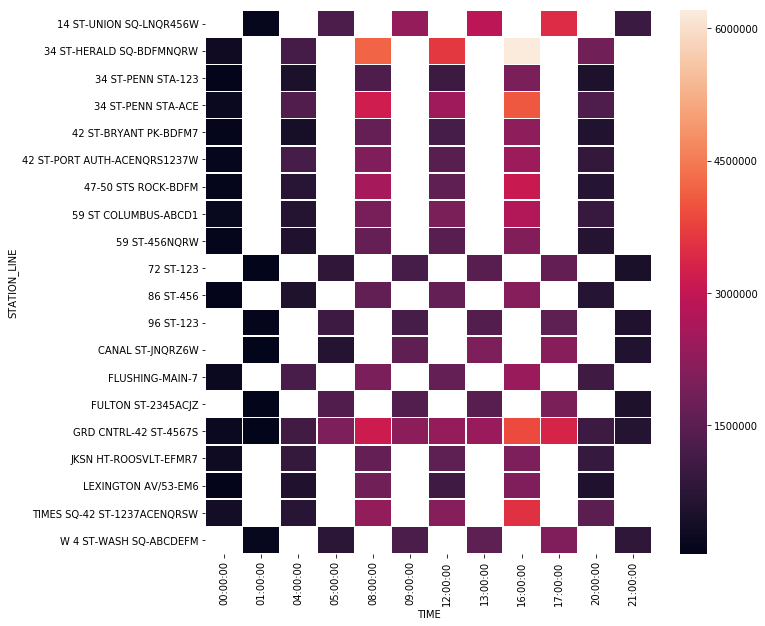

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(weekday_pivot, linewidth=0.5, ax=ax)

In [21]:
def weekend(x):
    if x <= 4:
        return 1
    else:
        return 0

In [22]:
df_hour_station['WEEKDAY'] = df_hour_station['DAY_CODE'].apply(weekend)

In [23]:
df_w = df_hour_station.groupby(['STATION_LINE','WEEKDAY'])['HOURLY_TOTAL'].mean().unstack()
df_w['WEEK_RATIO'] = (df_w[1])/(df_w[0])
final_df = df_w.dropna()
final_df.sort_values(by='WEEK_RATIO')

WEEKDAY,0,1,WEEK_RATIO
STATION_LINE,,,
ORCHARD BEACH-6,660.833333,239.433333,0.362320
RIT-MANHATTAN-R,6273.416667,4705.800000,0.750118
RIT-ROOSEVELT-R,9265.500000,7984.600000,0.861756
PRINCE ST-NRW,65195.333333,63659.900000,0.976449
BEACH 90 ST-AS,8882.750000,8708.366667,0.980368
QUEENSBORO PLZ-7NQW,44397.833333,43929.800000,0.989458
W 8 ST-AQUARIUM-FQ,13519.083333,13814.600000,1.021859
CONEY IS-STILLW-DFNQ,68204.583333,70039.433333,1.026902
AQUEDUCT RACETR-A,6147.000000,6314.966667,1.027325


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


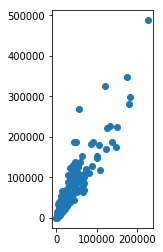

In [24]:
plt.scatter(final_df[0],final_df[1])
plt.axes().set_aspect('equal')
plt.show()